In [16]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
from typing import Optional
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from pathlib import Path
import pywt
import warnings
import torchsummary
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Times New Roman'

In [10]:
torch.manual_seed(42)
np.random.seed(42)

In [11]:
class SSVEPDataset(Dataset):
    """SSVEP Dataset for PyTorch"""
    
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [12]:
class ChannelWiseSpectralCLDNN(nn.Module):

    def __init__(self, freq_bins, time_bins, n_channels, n_classes, pos_dim: int = 16):
        super().__init__()
        self.n_channels = n_channels

        # per-channel CNN (weight sharing)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)  # F,T → F/2, T/2
        )
        self.cnn_out_dim = (freq_bins // 2) * (time_bins // 2) * 16

        self.chan_emb = nn.Embedding(n_channels, pos_dim)

        self.lstm = nn.LSTM(
            input_size=self.cnn_out_dim + pos_dim,
            hidden_size=128,
            batch_first=True
        )
        self.classifier = nn.Linear(128, n_classes)

    def forward(self, x, chan_ids: Optional[torch.Tensor] = None):
        B, C, F, T = x.shape
        if C != self.n_channels:
            raise ValueError(f"Expected {self.n_channels} channels, got {C}")

        x = x.view(B * C, 1, F, T)          # Treat each channel as 1×F×T image
        x = self.cnn(x)                     # (B*C, 16, F/2, T/2)
        x = x.view(B, C, -1)                # (B, C, cnn_out_dim)

        # 2. Add channel ID embedding (auto 0..C-1 if not provided)
        if chan_ids is None:
            chan_ids = torch.arange(C, device=x.device).unsqueeze(0).expand(B, C)
        pos = self.chan_emb(chan_ids)       # (B, C, pos_dim)
        x = torch.cat([x, pos], dim=-1)     # (B, C, cnn_out_dim + pos_dim)

        # 3. LSTM across channels
        _, (h, _) = self.lstm(x)            # h: (1, B, 128)
        return self.classifier(h.squeeze(0))  # (B, n_classes)

In [13]:
def load_chars_data(data_dir):
    """Load all character data from chars folder - each trial as separate sample"""
    
    data_dir = Path(data_dir)
    char_files = sorted(data_dir.glob("S*_chars.npy"))
    
    all_data = []
    all_labels = []

    for file_path in char_files:
        try:
            data = np.load(file_path)
            
            # Data shape: (26, 6, 64, 250) -> (26 chars, 6 trials, 64 channels, 250 time points)
            n_chars, n_trials, n_channels, n_times = data.shape
            
            # Convert each trial to independent samples
            # (26, 6, 64, 250) -> (26*6, 64, 250) = (156, 64, 250)
            data_reshaped = data.reshape(-1, n_channels, n_times)
            
            # Generate labels for each character's 6 trials
            # Character A(0)'s 6 trials: [0, 0, 0, 0, 0, 0]
            # Character B(1)'s 6 trials: [1, 1, 1, 1, 1, 1]
            # ...
            labels = np.arange(n_chars).repeat(n_trials)
            
            all_data.append(data_reshaped)
            all_labels.append(labels)
       
        except Exception as e:
            print(f"Error loading {file_path.name}: {e}")
    
    # Concatenate all data
    X = np.concatenate(all_data, axis=0)
    y = np.concatenate(all_labels, axis=0)
    
    return X, y

# STFT transform function for all channels
def apply_stft_transform(data, sampling_rate=250):
    """Apply STFT transform to all EEG channels"""
    
    from scipy import signal as sp_signal
    
    # STFT parameters
    nperseg = 128
    noverlap = 112
    nfft = 512
    
    if len(data.shape) == 3:
        # (samples, channels, time) - use all channels
        n_samples, n_channels, n_times = data.shape

        stft_data = []
        for sample_idx in range(n_samples):
            
            channels_stft = []
            for ch in range(n_channels):
                f, t, Zxx = sp_signal.stft(data[sample_idx, ch, :],
                                           fs=sampling_rate,
                                           nperseg=nperseg,
                                           noverlap=noverlap,
                                           nfft=nfft)
                power = np.abs(Zxx) ** 2
                channels_stft.append(power)
            
            stft_data.append(np.stack(channels_stft, axis=0))
        
        stft_data = np.array(stft_data)  # (samples, channels, freq, time)
        
    else:
        raise ValueError(f"Expected 3D data, got {data.shape}")
    
    print(f"Output shape: {stft_data.shape}")
    print(f"Channels: {stft_data.shape[1]}, Freq: {stft_data.shape[2]}, Time: {stft_data.shape[3]}")
    
    return stft_data

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    """Train the model with checkpoint saving and early stopping"""
    
    device = torch.device('mps' if torch.mps.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 
                           lr=learning_rate, 
                           weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                     T_max=num_epochs / 2, 
                                                     eta_min=1e-6)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Early stopping parameters
    best_val_acc = 0.0
    patience = 10
    patience_counter = 0
    
    print(f"Training on device: {device}")
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Early stopping patience: {patience}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Scheduler step
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Early stopping and checkpoint saving
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies,
            }, 'best_model_checkpoint.pth')
            print(f"New best model saved! Val Acc: {val_acc:.2f}%")
        else:
            patience_counter += 1
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  Learning Rate: {current_lr:.6f}')
        print(f'  Best Val Acc: {best_val_acc:.2f}%, Patience: {patience_counter}/{patience}')
        print('-' * 50)
        
        # Early stopping check
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered! No improvement for {patience} epochs.")
            print(f"Best validation accuracy: {best_val_acc:.2f}%")
            break
    
    # Load best model
    checkpoint = torch.load('best_model_checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\nTraining completed! Best model loaded.")
    print(f"Final best validation accuracy: {best_val_acc:.2f}%")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, test_loader):
    """Evaluate the model on test set"""
    
    device = torch.device('mps' if torch.mps.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Calculate accuracy
    accuracy = 100. * sum(p == t for p, t in zip(all_predictions, all_targets)) / len(all_targets)
    
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_targets, all_predictions))
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return accuracy, all_predictions, all_targets

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training history"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(train_accuracies, label='Train Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

In [14]:
# Data loading and training using all channels
print("=" * 60)
print("Data loading and training using all channels")
print("=" * 60)

# Data loading
data_dir = "/Users/seungha/Desktop/KHU/Master/M2/Introduction to Deep Learning/Project/chars"
X, y = load_chars_data(data_dir)
print(f"\nTotal data shape: {X.shape}")
print(f"Label shape: {y.shape}")

# Apply STFT transform to all channels
print("\n" + "=" * 60)
print("Applying STFT transform (all channels)")
print("=" * 60)

X_stft = apply_stft_transform(X)
print(f"STFT transform completed. New shape: {X_stft.shape}")

# Create dataset
dataset = SSVEPDataset(X_stft, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"\nData split:")
print(f"Training data: {len(train_dataset)} samples")
print(f"Validation data: {len(val_dataset)} samples")
print(f"Test data: {len(test_dataset)} samples")

# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoader created (batch_size={batch_size})")


Data loading and training using all channels

Total data shape: (5460, 64, 250)
Label shape: (5460,)

Applying STFT transform (all channels)
Output shape: (5460, 64, 257, 17)
Channels: 64, Freq: 257, Time: 17
STFT transform completed. New shape: (5460, 64, 257, 17)

Data split:
Training data: 3821 samples
Validation data: 819 samples
Test data: 820 samples

DataLoader created (batch_size=32)


In [7]:
# Model creation and training
print("=" * 60)
print("Model creation and training")
print("=" * 60)

# Check STFT output shape
print(f"X_stft shape: {X_stft.shape}")
n_freq_bins = X_stft.shape[2]  # 257
n_time_bins = X_stft.shape[3]  # 17 (for 1-second data)
n_channels = X_stft.shape[1]   # 64
n_classes = len(np.unique(y)) # 26

print(f"Model input shape:")
print(f"  - Number of channels: {n_channels}")
print(f"  - Frequency bins: {n_freq_bins}")
print(f"  - Time bins: {n_time_bins}")
print(f"  - Number of classes: {n_classes}")

# Check data shape
print(f"\nData shape verification:")
print(f"X_stft: {X_stft.shape}")
print(f"y: {y.shape}")

# Check sample data
sample_data = X_stft[0]
print(f"Sample data shape: {sample_data.shape}")

# Create model
model = ChannelWiseSpectralCLDNN(
    freq_bins=n_freq_bins,
    time_bins=n_time_bins,
    n_channels=n_channels,
    n_classes=n_classes
)

print(f"\nModel created")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test model with sample data
print(f"\nModel test:")
test_input = torch.randn(1, n_channels, n_freq_bins, n_time_bins)
print(f"Test input shape: {test_input.shape}")
try:
    test_output = model(test_input)
    print(f"Test output shape: {test_output.shape}")
    print("Model test successful!")
except Exception as e:
    print(f"Model test failed: {e}")

# Start training
print("\n" + "=" * 60)
print("Starting training")
print("=" * 60)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, num_epochs=100, learning_rate=0.001
)

Model creation and training
X_stft shape: (5460, 64, 257, 17)
Model input shape:
  - Number of channels: 64
  - Frequency bins: 257
  - Time bins: 17
  - Number of classes: 26

Data shape verification:
X_stft: (5460, 64, 257, 17)
y: (5460,)
Sample data shape: (64, 257, 17)

Model created
Number of parameters: 8,467,914

Model test:
Test input shape: torch.Size([1, 64, 257, 17])
Test output shape: torch.Size([1, 26])
Model test successful!

Starting training
Training on device: mps
Number of parameters: 8,467,914
Early stopping patience: 10
New best model saved! Val Acc: 13.80%
Epoch 1/100:
  Train Loss: 3.2109, Train Acc: 9.26%
  Val Loss: 3.1475, Val Acc: 13.80%
  Learning Rate: 0.000999
  Best Val Acc: 13.80%, Patience: 0/10
--------------------------------------------------
New best model saved! Val Acc: 22.71%
Epoch 2/100:
  Train Loss: 2.9905, Train Acc: 23.61%
  Val Loss: 2.9369, Val Acc: 22.71%
  Learning Rate: 0.000996
  Best Val Acc: 22.71%, Patience: 0/10
--------------------

Visualization and evaluation of training results

Loading best model for testing
Best model loaded from epoch 25
Best validation accuracy: 65.57%

Test data evaluation with best model
Test Accuracy: 70.61%

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        34
           1       0.79      0.82      0.80        40
           2       0.88      0.70      0.78        33
           3       0.53      0.65      0.59        26
           4       0.59      0.70      0.64        33
           5       0.69      0.62      0.66        40
           6       0.68      0.66      0.67        29
           7       0.55      0.50      0.52        24
           8       0.78      0.74      0.76        34
           9       0.86      0.71      0.78        42
          10       0.65      0.77      0.70        26
          11       0.73      0.59      0.66        32
          12       0.50      0.73      0.59        26
          13 

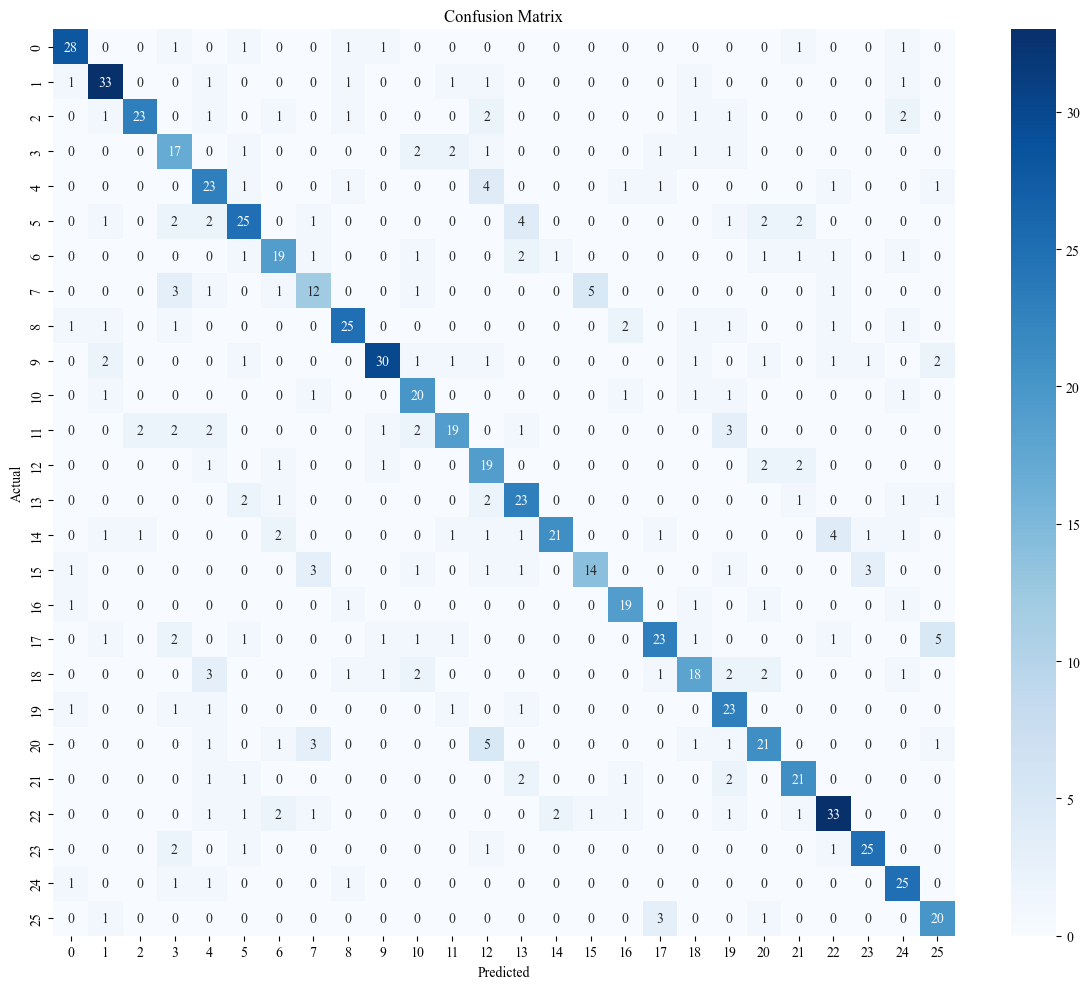


Final results:
Test accuracy: 70.61%
Best validation accuracy: 65.57%
Best training accuracy: 99.95%


In [17]:
# Visualization and evaluation of training results
print("=" * 60)
print("Visualization and evaluation of training results")
print("=" * 60)

# Plot training history
# plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

# Load best model for testing
print("\n" + "=" * 60)
print("Loading best model for testing")
print("=" * 60)

# Load the best model checkpoint
checkpoint = torch.load('best_model_batch32.pth')
model.load_state_dict(checkpoint['model_state_dict'])

print(f"Best model loaded from epoch {checkpoint['epoch'] + 1}")
print(f"Best validation accuracy: {checkpoint['best_val_acc']:.2f}%")

# Evaluate best model on test data
print("\n" + "=" * 60)
print("Test data evaluation with best model")
print("=" * 60)

test_accuracy, predictions, targets = evaluate_model(model, test_loader)

print(f"\nFinal results:")
print(f"Test accuracy: {test_accuracy:.2f}%")
print(f"Best validation accuracy: {checkpoint['best_val_acc']:.2f}%")
print(f"Best training accuracy: {max(checkpoint['train_accuracies']):.2f}%")